#### NOVA IMS / BSc in Data Science / Big Data Analysis 2024/2025
# <b>Group Project
#### Notebook `Loan Approval Classification`

#### Group:
- `Laura Matias (20221836)`
- `Marta Almendra (20221878)`
- `Matilde Casimiro (20221940)` 
- `Teresa Simão (20221873)` 

#### Dataset obtained from:
https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data?resource=download

#### Definition of the problem and objectives

This dataset consists of both categorical and continuous features relevant to credit risk and financial decision-making. It includes key variables such as applicant demographics, financial history, and loan details, structured to support binary classification. Using Apache Spark, we aim to build and evaluate a binary classifier to predict the loan_status variable, determining whether a loan application is approved or not. This notebook demonstrates the scalability and efficiency of Spark for processing and analyzing complex datasets in classification tasks.

#### Import libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from operator import add
from functools import reduce

from pyspark.sql.functions import *
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, StringType, DoubleType, StructType, StructField, TimestampType
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Normalizer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import SQLTransformer
from pyspark.ml.stat import Correlation

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

#### Import the data

In [0]:
file_location = "/FileStore/tables/loan_data.csv/loan_data.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
loan_data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(loan_data)

person_age person_gender person_education person_income person_emp_exp person_home_ownership loan_amnt loan_intent loan_int_rate loan_percent_income cb_person_cred_hist_length credit_score previous_loan_defaults_on_file loan_status 22.0 female Master 71948.0 0 RENT 35000.0 PERSONAL 16.02 0.49 3.0 561 No 1 21.0 female High School 12282.0 0 OWN 1000.0 EDUCATION 11.14 0.08 2.0 504 Yes 0 25.0 female High School 12438.0 3 MORTGAGE 5500.0 MEDICAL 12.87 0.44 3.0 635 No 1 23.0 female Bachelor 79753.0 0 RENT 35000.0 MEDICAL 15.23 0.44 2.0 675 No 1 24.0 male Master 66135.0 1 RENT 35000.0 MEDICAL 14.27 0.53 4.0 586 No 1 21.0 female High School 12951.0 0 OWN 2500.0 VENTURE 7.14 0.19 2.0 532 No 1 26.0 female Bachelor 93471.0 1 RENT 35000.0 EDUCATION 12.42 0.37 3.0 701 No 1 24.0 female High School 95550.0 5 RENT 35000.0 MEDICAL 11.11 0.37 4.0 585 No 1 24.0 female Associate 100684.0 3 RENT 35000.0 PERSONAL 8.9 0.35 2.0 544 No 1 21.0 female High School 12739.0 0 OWN 1600.0 VENTURE 14.74 0.13 3.0 640 No 1 22.0 female High School 102985.0 0 RENT 35000.0 VENTURE 10.37 0.34 4.0 621 No 1 21.0 female Associate 13113.0 0 OWN 4500.0 HOMEIMPROVEMENT 8.63 0.34 2.0 651 No 1 23.0 male Bachelor 114860.0 3 RENT 35000.0 VENTURE 7.9 0.3 2.0 573 No 1 26.0 male Master 130713.0 0 RENT 35000.0 EDUCATION 18.39 0.27 4.0 708 No 1 23.0 female Associate 138998.0 0 RENT 35000.0 EDUCATION 7.9 0.25 4.0 583 No 0 23.0 female Master 600891.0 5 MORTGAGE 30000.0 DEBTCONSOLIDATION 10.65 0.05 3.0 670 Yes 0 23.0 male Bachelor 144943.0 0 RENT 35000.0 EDUCATION 7.9 0.24 4.0 663 No 0 23.0 female High School 111369.0 0 RENT 35000.0 MEDICAL 20.0 0.31 4.0 694 No 1 23.0 male Bachelor 136628.0 0 RENT 35000.0 DEBTCONSOLIDATION 18.25 0.26 4.0 709 No 1 24.0 female Master 14283.0 1 MORTGAGE 1750.0 EDUCATION 10.99 0.12 2.0 679 No 1 25.0 male Bachelor 195718.0 0 RENT 35000.0 VENTURE 7.49 0.18 4.0 684 Yes 0 25.0 male High School 165792.0 4 RENT 34800.0 PERSONAL 16.77 0.21 2.0 662 No 0 22.0 female Master 79255.0 0 RENT 34000.0 EDUCATION 17.58 0.43 4.0 691 No 1 24.0 female Bachelor 13866.0 0 OWN 1500.0 PERSONAL 7.29 0.11 3.0 600 Yes 0 22.0 male Bachelor 97420.0 1 RENT 33950.0 PERSONAL 14.54 0.35 4.0 691 No 1 24.0 female High School 82443.0 0 RENT 33000.0 HOMEIMPROVEMENT 12.68 0.4 3.0 654 No 1 21.0 female Associate 14288.0 0 MORTGAGE 4575.0 VENTURE 17.74 0.32 3.0 626 No 1 23.0 male High School 14293.0 0 OWN 1400.0 PERSONAL 9.32 0.1 3.0 607 No 0 24.0 female Bachelor 79054.0 1 RENT 32500.0 HOMEIMPROVEMENT 9.99 0.41 3.0 700 No 1 21.0 female Bachelor 14988.0 0 OTHER 4000.0 EDUCATION 12.84 0.27 2.0 553 No 1 21.0 male High School 14858.0 0 OWN 2000.0 MEDICAL 11.12 0.13 3.0 589 No 1 25.0 male Bachelor 144855.0 1 RENT 32000.0 VENTURE 6.62 0.22 2.0 586 Yes 0 26.0 male Bachelor 114645.0 2 RENT 31050.0 HOMEIMPROVEMENT 14.17 0.27 3.0 681 No 1 25.0 female High School 368115.0 3 RENT 24250.0 DEBTCONSOLIDATION 13.85 0.07 3.0 567 Yes 0 26.0 female Associate 361076.0 1 MORTGAGE 7800.0 MEDICAL 13.49 0.02 4.0 669 No 0 21.0 male Associate 15150.0 0 OWN 2500.0 EDUCATION 7.51 0.17 4.0 600 No 1 22.0 female Bachelor 58868.0 0 RENT 30000.0 EDUCATION 18.39 0.51 2.0 606 No 1 24.0 male High School 78026.0 3 RENT 30000.0 DEBTCONSOLIDATION 14.54 0.38 3.0 582 No 1 25.0 male Bachelor 90785.0 4 RENT 30000.0 HOMEIMPROVEMENT 16.89 0.33 4.0 649 No 1 23.0 female High School 86811.0 0 RENT 30000.0 DEBTCONSOLIDATION 11.01 0.35 4.0 602 No 1 26.0 male Bachelor 75503.0 5 RENT 30000.0 MEDICAL 17.99 0.4 2.0 616 No 1 24.0 female High School 15082.0 0 OWN 2500.0 VENTURE 12.69 0.17 3.0 631 No 1 26.0 male Bachelor 361293.0 5 MORTGAGE 20000.0 VENTURE 7.88 0.06 4.0 684 Yes 0 23.0 male High School 361547.0 0 OWN 24250.0 EDUCATION 19.41 0.07 2.0 637 Yes 0 26.0 male Master 360680.0 5 OWN 10000.0 HOMEIMPROVEMENT 10.38 0.03 4.0 649 No 0 26.0 male Bachelor 360977.0 5 MORTGAGE 25000.0 EDUCATION 15.33 0.07 3.0 695 Yes 0 25.0 female Bachelor 361244.0 2 MORTGAGE 18000.0 HOMEIMPROVEMENT 16.45 0.05 3.0 620 No 0 26.0 male Bachelor 98230.0 2 RENT 30000.0 PER

Databricks data profile. Run in Databricks to view.

## 1. Preprocessing and Exploratory Data Analysis

#### 1.1. Initial look at the data

In [0]:
loan_data.printSchema()

root
 |-- person_age: string (nullable = true)
 |-- person_gender: string (nullable = true)
 |-- person_education: string (nullable = true)
 |-- person_income: string (nullable = true)
 |-- person_emp_exp: string (nullable = true)
 |-- person_home_ownership: string (nullable = true)
 |-- loan_amnt: string (nullable = true)
 |-- loan_intent: string (nullable = true)
 |-- loan_int_rate: string (nullable = true)
 |-- loan_percent_income: string (nullable = true)
 |-- cb_person_cred_hist_length: string (nullable = true)
 |-- credit_score: string (nullable = true)
 |-- previous_loan_defaults_on_file: string (nullable = true)
 |-- loan_status: string (nullable = true)



Features of the Dataset

- person_age: Age of the person.
- person_gender: Gender of the person.
- person_education: Highest education level.
- person_income: Annual income.
- person_emp_exp: Years of employment experience.
- person_home_ownership: Home ownership status (e.g., rent, own, mortgage).
- loan_amnt: Loan amount requested.
- loan_intent: Purpose of the loan.
- loan_int_rate: Loan interest rate.
- loan_percent_income: Loan amount as a percentage of annual income.
- person_education: Number of artists contributing to the song.
- cb_person_cred_hist_length: Length of credit history in years.
- credit_score: Credit score of the person
- previous_loan_defaults_on_file: Indicator of previous loan defaults	
- loan_status (target variable): Loan approval status: 1 = approved; 0 = rejected	


In [0]:
print(f"Number of rows: \n {loan_data.count()}")
print(f"\nNumber of columns: \n {len(loan_data.columns)}")

Number of rows: 
 45000

Number of columns: 
 14


#### 1.2. Correcting Data Types
It's important ensures that the columns in the loan_data DataFrame have the correct data types, so we converted specific columns to floats and integers as needed for accurate analysis and processing later on.

In [0]:
columns_to_float = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

for column in columns_to_float:
    loan_data = loan_data.withColumn(column, loan_data[column].cast(DoubleType()))

In [0]:
columns_to_int = ['person_emp_exp', 'credit_score', 'loan_status']

for column in columns_to_int:
    loan_data = loan_data.withColumn(column, loan_data[column].cast(IntegerType()))

In [0]:
loan_data.printSchema()

root
 |-- person_age: double (nullable = true)
 |-- person_gender: string (nullable = true)
 |-- person_education: string (nullable = true)
 |-- person_income: double (nullable = true)
 |-- person_emp_exp: integer (nullable = true)
 |-- person_home_ownership: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- loan_intent: string (nullable = true)
 |-- loan_int_rate: double (nullable = true)
 |-- loan_percent_income: double (nullable = true)
 |-- cb_person_cred_hist_length: double (nullable = true)
 |-- credit_score: integer (nullable = true)
 |-- previous_loan_defaults_on_file: string (nullable = true)
 |-- loan_status: integer (nullable = true)



#### 1.3. Missing Values

In [0]:

#  count and print the number of rows in the dataset that have at least one missing value
filter_conditions = [col(c).isNull() for c in loan_data.columns]

combined_condition = reduce(lambda x, y: x | y, filter_conditions)

rows_with_missing_values_count = loan_data.filter(combined_condition).count()

print("Number of rows with missing values:", rows_with_missing_values_count)

Number of rows with missing values: 0


There are no missing values in this dataset.

#### 1.4. Duplicate Values

In [0]:
rows_before = loan_data.count()

df_no_duplicates = loan_data.dropDuplicates()

rows_after = df_no_duplicates.count()

has_duplicates = rows_before != rows_after

print("Has duplicate rows:", has_duplicates)

Has duplicate rows: False


There are no duplicate values in this dataset.

#### 1.5. Summary Statistics

In [0]:
loan_data.select(loan_data.columns[0:5]).describe().show()

+-------+-----------------+-------------+----------------+-----------------+-----------------+
|summary|       person_age|person_gender|person_education|    person_income|   person_emp_exp|
+-------+-----------------+-------------+----------------+-----------------+-----------------+
|  count|            45000|        45000|           45000|            45000|            45000|
|   mean|27.76417777777778|         null|            null|80319.05322222222|5.410333333333333|
| stddev|6.045108211348448|         null|            null|80422.49863189492|6.063532086574569|
|    min|             20.0|       female|       Associate|           8000.0|                0|
|    max|            144.0|         male|          Master|        7200766.0|              125|
+-------+-----------------+-------------+----------------+-----------------+-----------------+



In [0]:
loan_data.select(loan_data.columns[5:10]).describe().show()

+-------+---------------------+-----------------+-----------------+------------------+-------------------+
|summary|person_home_ownership|        loan_amnt|      loan_intent|     loan_int_rate|loan_percent_income|
+-------+---------------------+-----------------+-----------------+------------------+-------------------+
|  count|                45000|            45000|            45000|             45000|              45000|
|   mean|                 null|9583.157555555556|             null|11.006605777777724| 0.1397248888888964|
| stddev|                 null|6314.886690541181|             null|2.9788082802253895|0.08721230801404005|
|    min|             MORTGAGE|            500.0|DEBTCONSOLIDATION|              5.42|                0.0|
|    max|                 RENT|          35000.0|          VENTURE|              20.0|               0.66|
+-------+---------------------+-----------------+-----------------+------------------+-------------------+



In [0]:
loan_data.select(loan_data.columns[10:]).describe().show()

+-------+--------------------------+-----------------+------------------------------+------------------+
|summary|cb_person_cred_hist_length|     credit_score|previous_loan_defaults_on_file|       loan_status|
+-------+--------------------------+-----------------+------------------------------+------------------+
|  count|                     45000|            45000|                         45000|             45000|
|   mean|        5.8674888888888885|632.6087555555556|                          null|0.2222222222222222|
| stddev|         3.879701845161865|50.43586500074239|                          null|0.4157443290486463|
|    min|                       2.0|              390|                            No|                 0|
|    max|                      30.0|              850|                           Yes|                 1|
+-------+--------------------------+-----------------+------------------------------+------------------+



#### 1.6. Variables Distributions

##### 1.6.1 Categorical Variables

In [0]:
loan_data.groupBy("loan_status").count().orderBy("count", ascending=False).display()
loan_data.groupBy("person_gender", "loan_status").count().display()
loan_data.groupBy("person_education", "loan_status").count().display()
loan_data.groupBy("person_home_ownership", "loan_status").count().display()
loan_data.groupBy("loan_intent", "loan_status").count().display()
loan_data.groupBy("previous_loan_defaults_on_file", "loan_status").count().display()

loan_status count 0 35000 1 10000

Databricks visualization. Run in Databricks to view.

person_gender loan_status count male 0 19326 female 1 4485 female 0 15674 male 1 5515

Databricks visualization. Run in Databricks to view.

person_education loan_status count Doctorate 0 479 Bachelor 0 10381 High School 1 2671 Master 0 5461 Associate 0 9378 Doctorate 1 142 High School 0 9301 Bachelor 1 3018 Master 1 1519 Associate 1 2650

Databricks visualization. Run in Databricks to view.

person_home_ownership loan_status count OTHER 1 39 RENT 1 7595 RENT 0 15848 OWN 1 222 MORTGAGE 0 16345 MORTGAGE 1 2144 OTHER 0 78 OWN 0 2729

Databricks visualization. Run in Databricks to view.

loan_intent loan_status count DEBTCONSOLIDATION 1 2163 MEDICAL 1 2378 HOMEIMPROVEMENT 0 3525 PERSONAL 0 6031 EDUCATION 1 1552 HOMEIMPROVEMENT 1 1258 EDUCATION 0 7601 MEDICAL 0 6170 DEBTCONSOLIDATION 0 4982 VENTURE 0 6691 PERSONAL 1 1521 VENTURE 1 1128

Databricks visualization. Run in Databricks to view.

previous_loan_defaults_on_file loan_status count Yes 0 22858 No 1 10000 No 0 12142

Databricks visualization. Run in Databricks to view.

Regarding loan approval, we discovered that rejections are more common than approvals.
Individuals with only a high school, bachelor's, or associate degree are refused more frequently than those with a higher education, and people paying mortgages or rent are more likely to be denied than homeowners. In terms of loan intent, medical requirements are the most typical cause for approval, followed by debt consolidation. Lastly, regarding a previous loan default on file, we discovered that candidates with previous defaults had a higher likelihood of loan rejection compared to those with no defaults.

The dataset is imbalanced.

##### 1.6.2 Numerical Varibles

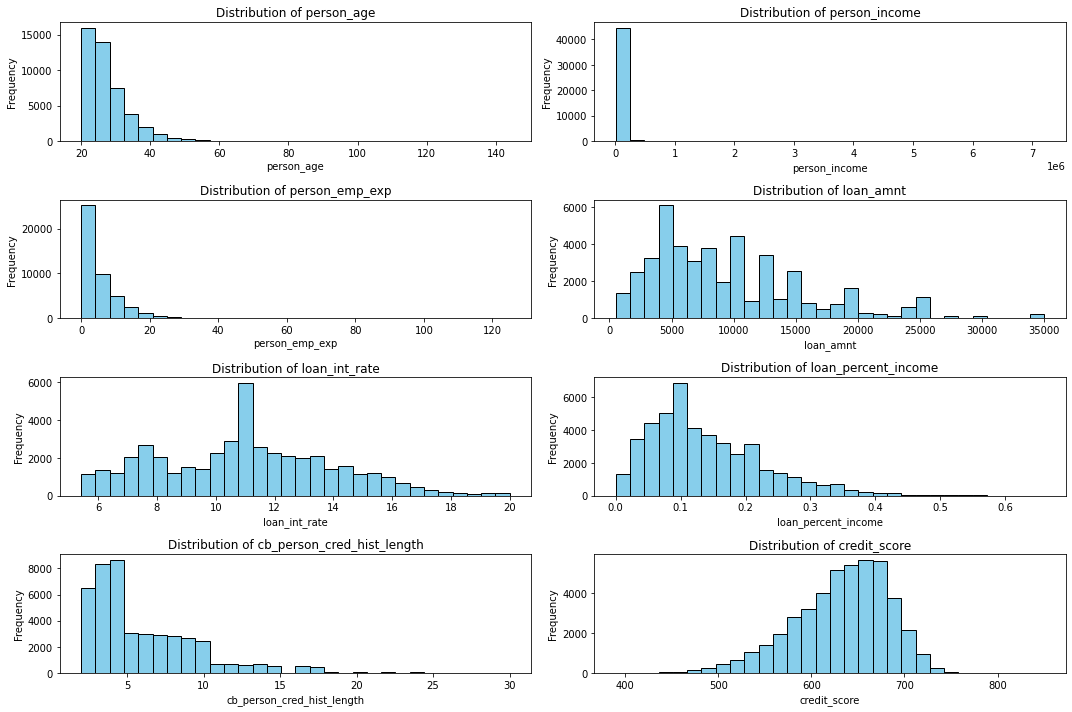

In [0]:
numerical_columns = ["person_age", "person_income", "person_emp_exp", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", "credit_score"]

numerical_data = {}
for col in numerical_columns:
    numerical_data[col] = loan_data.select(col).rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(15, 10))
num_vars = len(numerical_columns)
cols = 2  
rows = (num_vars // cols) + (num_vars % cols > 0)

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(rows, cols, i)
    plt.hist(numerical_data[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()



The data exhibits various forms of skewness, indicating that transformations may be required for certain features, however, the skewness in many distributions might reflect real-world disparities, such as income inequality or variations in financial behavior.

#### 1.7. Data Inconsistencies and Extreme Values

In [0]:
loan_data.createOrReplaceTempView("LoanDataTable")

##### 1.7.1. Age

Found suspiciously high ages, thus we concentrated on ages less than 95 for reliability.

In [0]:
%sql
SELECT *
FROM LoanDataTable
WHERE person_age > 95

person_age person_gender person_education person_income person_emp_exp person_home_ownership loan_amnt loan_intent loan_int_rate loan_percent_income cb_person_cred_hist_length credit_score previous_loan_defaults_on_file loan_status 144.0 male Bachelor 300616.0 125 RENT 4800.0 VENTURE 13.57 0.02 3.0 789 No 0 144.0 male Associate 241424.0 121 MORTGAGE 6000.0 EDUCATION 11.86 0.02 2.0 807 No 0 123.0 female High School 97140.0 101 RENT 20400.0 EDUCATION 10.25 0.21 3.0 805 Yes 0 123.0 male Bachelor 94723.0 100 RENT 20000.0 VENTURE 11.01 0.21 4.0 714 Yes 0 144.0 female Associate 7200766.0 124 MORTGAGE 5000.0 PERSONAL 12.73 0.0 25.0 850 No 0 116.0 male Bachelor 5545545.0 93 MORTGAGE 3823.0 VENTURE 12.15 0.0 24.0 708 No 0 109.0 male High School 5556399.0 85 MORTGAGE 6195.0 VENTURE 12.58 0.0 22.0 792 No 0

In [0]:
loan_data = loan_data.filter(loan_data.person_age < 95)

##### 1.7.2. Income

We also discovered people with salaries of more than 1 million seeking for minor loans, which seemed like a possible inconsistency. 

In [0]:
%sql
SELECT *
FROM LoanDataTable
WHERE person_income > 1000000

person_age person_gender person_education person_income person_emp_exp person_home_ownership loan_amnt loan_intent loan_int_rate loan_percent_income cb_person_cred_hist_length credit_score previous_loan_defaults_on_file loan_status 32.0 female High School 1440746.0 6 MORTGAGE 12000.0 VENTURE 7.51 0.01 8.0 613 No 0 34.0 male Bachelor 1138723.0 12 MORTGAGE 2000.0 PERSONAL 9.99 0.0 7.0 609 Yes 0 36.0 male Doctorate 1440982.0 15 OWN 10000.0 MEDICAL 6.54 0.01 11.0 682 Yes 0 40.0 female Bachelor 1440915.0 19 MORTGAGE 10000.0 MEDICAL 11.01 0.01 16.0 637 Yes 0 50.0 male High School 1081082.0 28 MORTGAGE 30000.0 DEBTCONSOLIDATION 12.69 0.03 15.0 643 No 0 36.0 female High School 1081254.0 14 MORTGAGE 6000.0 PERSONAL 11.01 0.01 12.0 600 Yes 0 42.0 male High School 1067921.0 20 RENT 20000.0 EDUCATION 11.01 0.02 17.0 529 Yes 0 42.0 male High School 2448661.0 16 RENT 8450.0 VENTURE 12.29 0.0 15.0 635 Yes 0 37.0 male Associate 1081139.0 15 MORTGAGE 25000.0 PERSONAL 12.87 0.02 13.0 625 Yes 0 47.0 male High School 1635757.0 24 MORTGAGE 6600.0 VENTURE 7.74 0.0 17.0 591 Yes 0 44.0 male High School 1728974.0 20 MORTGAGE 6400.0 DEBTCONSOLIDATION 7.4 0.0 15.0 573 Yes 0 144.0 female Associate 7200766.0 124 MORTGAGE 5000.0 PERSONAL 12.73 0.0 25.0 850 No 0 58.0 male Master 1080918.0 40 RENT 19600.0 DEBTCONSOLIDATION 13.98 0.02 28.0 688 Yes 0 63.0 male High School 2139143.0 43 RENT 12025.0 EDUCATION 14.27 0.01 30.0 724 No 0 60.0 female High School 2280980.0 37 MORTGAGE 1500.0 PERSONAL 11.01 0.0 21.0 682 Yes 0 47.0 male Associate 1621992.0 27 MORTGAGE 6835.0 MEDICAL 7.66 0.0 17.0 555 Yes 0 36.0 female Bachelor 1097671.0 16 MORTGAGE 4824.0 PERSONAL 10.71 0.0 11.0 669 Yes 0 47.0 male Associate 1661567.0 22 MORTGAGE 6545.0 MEDICAL 7.65 0.0 17.0 622 Yes 0 42.0 male High School 2012954.0 19 MORTGAGE 9121.0 VENTURE 11.74 0.0 16.0 664 No 0 116.0 male Bachelor 5545545.0 93 MORTGAGE 3823.0 VENTURE 12.15 0.0 24.0 708 No 0 109.0 male High School 5556399.0 85 MORTGAGE 6195.0 VENTURE 12.58 0.0 22.0 792 No 0 39.0 male High School 1076036.0 17 MORTGAGE 23116.0 PERSONAL 12.17 0.02 15.0 661 No 0 46.0 male High School 1080952.0 27 MORTGAGE 28389.0 PERSONAL 12.75 0.03 15.0 639 Yes 0 46.0 male Associate 1741243.0 22 MORTGAGE 12011.0 VENTURE 10.42 0.01 18.0 655 Yes 0

##### 1.7.3. Employment Experience

Another potential inconsistency or extreme value was observed among candidates with exceptionally high years of work experience, so we decided to look further into it.

In [0]:
%sql
SELECT *
FROM LoanDataTable
WHERE person_emp_exp > 60

person_age person_gender person_education person_income person_emp_exp person_home_ownership loan_amnt loan_intent loan_int_rate loan_percent_income cb_person_cred_hist_length credit_score previous_loan_defaults_on_file loan_status 144.0 male Bachelor 300616.0 125 RENT 4800.0 VENTURE 13.57 0.02 3.0 789 No 0 144.0 male Associate 241424.0 121 MORTGAGE 6000.0 EDUCATION 11.86 0.02 2.0 807 No 0 123.0 female High School 97140.0 101 RENT 20400.0 EDUCATION 10.25 0.21 3.0 805 Yes 0 123.0 male Bachelor 94723.0 100 RENT 20000.0 VENTURE 11.01 0.21 4.0 714 Yes 0 144.0 female Associate 7200766.0 124 MORTGAGE 5000.0 PERSONAL 12.73 0.0 25.0 850 No 0 94.0 male High School 29738.0 76 RENT 6500.0 MEDICAL 11.01 0.22 27.0 773 No 0 80.0 male High School 77894.0 62 RENT 6800.0 MEDICAL 11.71 0.09 25.0 673 No 0 84.0 male High School 114705.0 61 MORTGAGE 10000.0 PERSONAL 7.51 0.09 24.0 784 Yes 0 116.0 male Bachelor 5545545.0 93 MORTGAGE 3823.0 VENTURE 12.15 0.0 24.0 708 No 0 109.0 male High School 5556399.0 85 MORTGAGE 6195.0 VENTURE 12.58 0.0 22.0 792 No 0

In [0]:
print(f"Number of rows: \n {loan_data.count()}")

Number of rows: 
 44993


#### 1.8. Correlation Analysis

Spearman correlation is the most adequate for the loan_data because it measures the monotonic relationship between variables, rather than assuming a linear relationship like Pearson correlation. Since many features (such as income, age, and loan amount) exhibit skewed or non-linear distributions, Spearman's rank-based method is better suited to capture the strength and direction of these relationships.


In [0]:
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
corr_df = assembler.transform(loan_data).select("features")

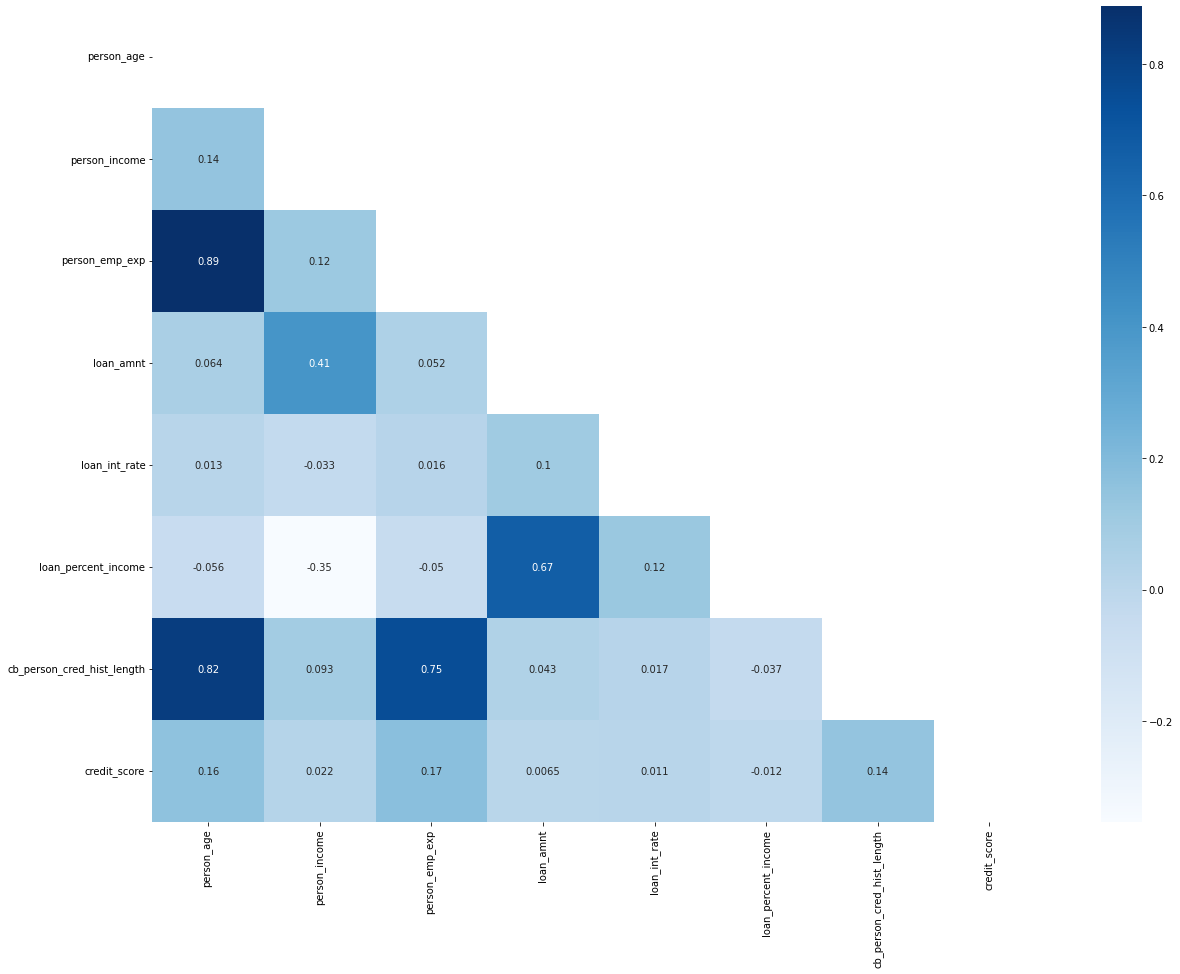

In [0]:
# Spearman Correlation
spearman_correlation = Correlation.corr(corr_df, "features", "spearman").collect()[0][0]

variable_index_mapping = {index: name for index, name in enumerate(numerical_columns)}

mask = np.triu(np.ones_like(spearman_correlation.toArray(), dtype=bool))

plt.figure(figsize=(20, 15))
sns.heatmap(spearman_correlation.toArray(), cmap="Blues", annot=True, xticklabels=numerical_columns, yticklabels=numerical_columns, mask=mask)
plt.show()

The correlation matrix shows strong positive correlations between person_age and person_emp_exp (0.89), indicating older individuals tend to have more work experience. There's a moderate positive correlation between loan_amnt and loan_percent_income (0.65), suggesting larger loans are associated with a higher percentage of income spent. A negative correlation between loan_int_rate and credit_score (-0.43) indicates higher credit scores often lead to lower interest rates. The other correlations are weak.

## 2. Data Preparation

#### 2.1. Feature Transformation

We applied StringIndexer to person_gender and previous_loan_defaults_on_file to transform these categorical variables into numerical binary columns (gender_binary and previous_loan_defaults_on_file_binary). This conversion allows us to use these variables in models that require numeric input.

In [0]:
indexer_gender = StringIndexer(inputCol="person_gender", outputCol="gender_binary").fit(loan_data)
indexer_previous = StringIndexer(inputCol="previous_loan_defaults_on_file",                     
                                 outputCol="previous_loan_defaults_on_file_binary").fit(loan_data)

loan_data = indexer_gender.transform(loan_data)
loan_data = indexer_previous.transform(loan_data)

#### 2.2. Feature Selection

We selected only the numerical columns to be used for the modelling.

In [0]:
model_cols = ["person_age","gender_binary", "person_income", "person_emp_exp", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", "credit_score","previous_loan_defaults_on_file_binary", "loan_status"]

loan_modelling = loan_data.select(model_cols)
loan_modelling.display()

person_age gender_binary person_income person_emp_exp loan_amnt loan_int_rate loan_percent_income cb_person_cred_hist_length credit_score previous_loan_defaults_on_file_binary loan_status 22.0 1.0 71948.0 0 35000.0 16.02 0.49 3.0 561 1.0 1 21.0 1.0 12282.0 0 1000.0 11.14 0.08 2.0 504 0.0 0 25.0 1.0 12438.0 3 5500.0 12.87 0.44 3.0 635 1.0 1 23.0 1.0 79753.0 0 35000.0 15.23 0.44 2.0 675 1.0 1 24.0 0.0 66135.0 1 35000.0 14.27 0.53 4.0 586 1.0 1 21.0 1.0 12951.0 0 2500.0 7.14 0.19 2.0 532 1.0 1 26.0 1.0 93471.0 1 35000.0 12.42 0.37 3.0 701 1.0 1 24.0 1.0 95550.0 5 35000.0 11.11 0.37 4.0 585 1.0 1 24.0 1.0 100684.0 3 35000.0 8.9 0.35 2.0 544 1.0 1 21.0 1.0 12739.0 0 1600.0 14.74 0.13 3.0 640 1.0 1 22.0 1.0 102985.0 0 35000.0 10.37 0.34 4.0 621 1.0 1 21.0 1.0 13113.0 0 4500.0 8.63 0.34 2.0 651 1.0 1 23.0 0.0 114860.0 3 35000.0 7.9 0.3 2.0 573 1.0 1 26.0 0.0 130713.0 0 35000.0 18.39 0.27 4.0 708 1.0 1 23.0 1.0 138998.0 0 35000.0 7.9 0.25 4.0 583 1.0 0 23.0 1.0 600891.0 5 30000.0 10.65 0.05 3.0 670 0.0 0 23.0 0.0 144943.0 0 35000.0 7.9 0.24 4.0 663 1.0 0 23.0 1.0 111369.0 0 35000.0 20.0 0.31 4.0 694 1.0 1 23.0 0.0 136628.0 0 35000.0 18.25 0.26 4.0 709 1.0 1 24.0 1.0 14283.0 1 1750.0 10.99 0.12 2.0 679 1.0 1 25.0 0.0 195718.0 0 35000.0 7.49 0.18 4.0 684 0.0 0 25.0 0.0 165792.0 4 34800.0 16.77 0.21 2.0 662 1.0 0 22.0 1.0 79255.0 0 34000.0 17.58 0.43 4.0 691 1.0 1 24.0 1.0 13866.0 0 1500.0 7.29 0.11 3.0 600 0.0 0 22.0 0.0 97420.0 1 33950.0 14.54 0.35 4.0 691 1.0 1 24.0 1.0 82443.0 0 33000.0 12.68 0.4 3.0 654 1.0 1 21.0 1.0 14288.0 0 4575.0 17.74 0.32 3.0 626 1.0 1 23.0 0.0 14293.0 0 1400.0 9.32 0.1 3.0 607 1.0 0 24.0 1.0 79054.0 1 32500.0 9.99 0.41 3.0 700 1.0 1 21.0 1.0 14988.0 0 4000.0 12.84 0.27 2.0 553 1.0 1 21.0 0.0 14858.0 0 2000.0 11.12 0.13 3.0 589 1.0 1 25.0 0.0 144855.0 1 32000.0 6.62 0.22 2.0 586 0.0 0 26.0 0.0 114645.0 2 31050.0 14.17 0.27 3.0 681 1.0 1 25.0 1.0 368115.0 3 24250.0 13.85 0.07 3.0 567 0.0 0 26.0 1.0 361076.0 1 7800.0 13.49 0.02 4.0 669 1.0 0 21.0 0.0 15150.0 0 2500.0 7.51 0.17 4.0 600 1.0 1 22.0 1.0 58868.0 0 30000.0 18.39 0.51 2.0 606 1.0 1 24.0 0.0 78026.0 3 30000.0 14.54 0.38 3.0 582 1.0 1 25.0 0.0 90785.0 4 30000.0 16.89 0.33 4.0 649 1.0 1 23.0 1.0 86811.0 0 30000.0 11.01 0.35 4.0 602 1.0 1 26.0 0.0 75503.0 5 30000.0 17.99 0.4 2.0 616 1.0 1 24.0 1.0 15082.0 0 2500.0 12.69 0.17 3.0 631 1.0 1 26.0 0.0 361293.0 5 20000.0 7.88 0.06 4.0 684 0.0 0 23.0 0.0 361547.0 0 24250.0 19.41 0.07 2.0 637 0.0 0 26.0 0.0 360680.0 5 10000.0 10.38 0.03 4.0 649 1.0 0 26.0 0.0 360977.0 5 25000.0 15.33 0.07 3.0 695 0.0 0 25.0 1.0 361244.0 2 18000.0 16.45 0.05 3.0 620 1.0 0 26.0 0.0 98230.0 2 30000.0 7.49 0.31 3.0 622 1.0 1 22.0 1.0 80838.0 0 30000.0 12.69 0.37 3.0 645 1.0 1 26.0 0.0 107957.0 2 30000.0 6.62 0.28 3.0 654 1.0 1 24.0 1.0 94649.0 2 30000.0 11.01 0.32 4.0 624 1.0 1 23.0 0.0 94550.0 1 30000.0 18.62 0.32 3.0 570 1.0 1 23.0 0.0 111153.0 3 30000.0 15.23 0.27 3.0 648 1.0 1 23.0 1.0 117250.0 0 30000.0 10.65 0.26 2.0 652 1.0 1 25.0 0.0 144985.0 3 30000.0 7.9 0.21 4.0 559 1.0 0 26.0 0.0 337133.0 7 10000.0 15.96 0.03 3.0 623 0.0 0 26.0 0.0 333566.0 2 20000.0 11.48 0.06 3.0 602 0.0 0 23.0 0.0 333399.0 1 35000.0 11.01 0.1 4.0 609 1.0 0 25.0 0.0 154793.0 1 30000.0 7.29 0.19 4.0 573 0.0 0 24.0 0.0 15229.0 1 1750.0 11.01 0.11 3.0 631 0.0 0 21.0 1.0 158338.0 0 30000.0 5.99 0.19 4.0 623 0.0 0 22.0 1.0 331034.0 0 12000.0 11.58 0.04 2.0 602 0.0 0 26.0 1.0 316466.0 6 10000.0 11.01 0.03 4.0 579 1.0 1 25.0 1.0 267671.0 0 25000.0 15.7 0.09 2.0 582 1.0 1 22.0 0.0 85191.0 0 29100.0 15.99 0.34 3.0 700 1.0 1 22.0 0.0 15013.0 0 1500.0 14.84 0.1 3.0 688 1.0 0 26.0 0.0 313100.0 3 28000.0 10.99 0.09 3.0 607 0.0 0 25.0 1.0 311952.0 0 20000.0 14.42 0.06 2.0 661 0.0 0 24.0 0.0 306897.0 5 9600.0 6.99 0.03 2.0 562 0.0 0 25.0 1.0 301136.0 0 25000.0 13.49 0.08 4.0 664 0.0 0 25.0 0.0 15162.0 1 3000.0 11.01 0.2 3.0 564 1.0 1 22.0 0.0 69042.0 0 28000.0 11.01 0.41 2.0 598 1.0 1 21.0 1.0 15307.0 0 3000.0 13.61 0.2 3.0 557 1.0 1 23.0 1.0 79183.0 0 28000.0 7.9 0.

#### 2.3. Vectorization and Scaling

It is necessary to combine multiple feature columns into a single vector column because Spark's machine learning algorithms require the input features to be in vector form. We are also performing Euclidean normalization to the vectorized values. 


In [0]:
assemble_cols = ["person_age", "person_income", "person_emp_exp", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", "credit_score", "gender_binary", "previous_loan_defaults_on_file_binary"]
assembler = VectorAssembler(inputCols=assemble_cols, outputCol="numeric_features") 


In [0]:
normalizer = Normalizer(inputCol='numeric_features', outputCol='features', p= 2.0)  


#### 2.4. Initiate the Pipeline

The Pipeline organizes the prior steps into a single process, which can then be fit and applied to the dataset in one go. This is useful for automating preprocessing and ensuring that the same transformations are applied consistently during training and testing.

In [0]:
pipeline = Pipeline(stages=[indexer_gender, indexer_previous, assembler, normalizer])

#### 2.5. Train-Test Split
We split the dataset into training and testing sets with a 70-30 ratio. We use caching to store the train and test datasets in memory, which can speed up the processing of subsequent operations. This is especially helpful when working with large datasets, as it avoids recomputing the same data multiple times.

In [0]:
train, test = loan_modelling.randomSplit([0.7, 0.3], 42) 
train.cache()
test.cache()

Out[29]: DataFrame[person_age: double, gender_binary: double, person_income: double, person_emp_exp: int, loan_amnt: double, loan_int_rate: double, loan_percent_income: double, cb_person_cred_hist_length: double, credit_score: int, previous_loan_defaults_on_file_binary: double, loan_status: int]

## 3. Modelling

#### 3.1. Logistic Regression Model

Logistic Regression is a model used for binary classification tasks. It works by estimating the probability of the positive class using input features. The output is then classified based on a threshold (in this case the standard 0.5). It is widely used for tasks like predicting customer churn, fraud detection, and loan approval due to its simplicity and efficiency.


##### 3.1.1. Train the Model

In [0]:
lr = LogisticRegression(featuresCol="features", labelCol="loan_status",predictionCol="prediction")

lr_evaluator = BinaryClassificationEvaluator(labelCol='loan_status', metricName='areaUnderROC')

pipeline.setStages([indexer_gender, indexer_previous, assembler, normalizer,lr])

Out[30]: Pipeline_61f6df6b46c6

In [0]:
lr_pipeline_model = pipeline.fit(train)
lr_results = lr_pipeline_model.transform(test)

##### 3.1.2. Evaluate the Model

In [0]:
print('Confusion Matrix')
lr_results.groupby("loan_status").pivot("prediction").count().show()

Confusion Matrix
+-----------+----+----+
|loan_status| 0.0| 1.0|
+-----------+----+----+
|          1|1054|1894|
|          0|9979| 497|
+-----------+----+----+



In [0]:
evaluator = BinaryClassificationEvaluator(labelCol='loan_status')
auc_eval  = evaluator.evaluate(lr_results)
print(f"Area under ROC curve: {auc_eval}")

Area under ROC curve: 0.9443886860604818


In [0]:
def plot_roc_curve(model_results, label_col="loan_status", prob_col="probability"):
    # Extract probabilities and labels
    predictions_and_labels = model_results.select(prob_col, label_col).rdd.map(
        lambda row: (row[prob_col][1], row[label_col]))

    # Thresholds and calculate TPR and FPR
    thresholds = np.arange(0.0, 1.1, 0.1)  # Thresholds from 0 to 1 with a step of 0.1
    tpr_values = []
    fpr_values = []

    for threshold in thresholds:
        # Apply the threshold to get predicted labels (1 if probability > threshold else 0)
        prediction_labels = predictions_and_labels.map(
            lambda x: (1 if x[0] >= threshold else 0, x[1]))

        # True Positives, False Positives, False Negatives, and True Negatives
        tp = prediction_labels.filter(lambda x: x[0] == 1 and x[1] == 1).count()
        fp = prediction_labels.filter(lambda x: x[0] == 1 and x[1] == 0).count()
        fn = prediction_labels.filter(lambda x: x[0] == 0 and x[1] == 1).count()
        tn = prediction_labels.filter(lambda x: x[0] == 0 and x[1] == 0).count()

        # Calculate TPR and FPR
        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0  # Avoid division by zero
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # Avoid division by zero

        tpr_values.append(tpr)
        fpr_values.append(fpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_values, tpr_values, color="green", lw=2, label="Model ROC Curve")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1, label="Random Guess")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

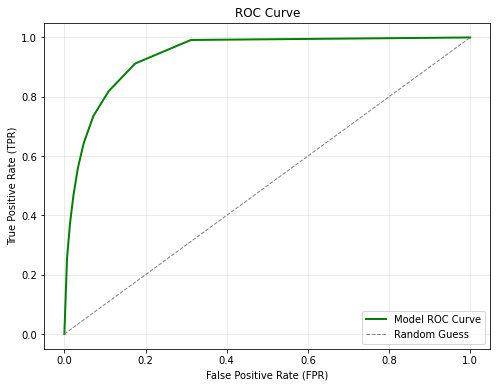

In [0]:
plot_roc_curve(lr_results)

#### 3.2. Random Forest Classifier

Random Forest Classifier is an ensemble learning model that combines multiple decision trees to improve classification accuracy. Each tree is trained on a random subset of the data, and the final prediction is made by taking a majority vote across all the trees. It is highly effective at handling complex datasets and is less prone to overfitting compared to a single decision tree. 

##### 3.2.1. Train the Model

In [0]:
rf = RandomForestClassifier(featuresCol="features", labelCol="loan_status", numTrees=100, maxDepth=5)

rf_evaluator = BinaryClassificationEvaluator(labelCol='loan_status', metricName='areaUnderROC')

pipeline.setStages([indexer_gender, indexer_previous, assembler, normalizer,rf])

Out[36]: Pipeline_61f6df6b46c6

In [0]:
rf_pipeline_model = pipeline.fit(train)
rf_results = rf_pipeline_model.transform(test)

##### 3.2.2. Evaluate the model

In [0]:
print('Confusion Matrix')
rf_results.groupby("loan_status").pivot("prediction").count().show()

Confusion Matrix
+-----------+-----+----+
|loan_status|  0.0| 1.0|
+-----------+-----+----+
|          1| 1335|1613|
|          0|10156| 320|
+-----------+-----+----+



In [0]:
evaluator = BinaryClassificationEvaluator(labelCol='loan_status')
auc_eval  = evaluator.evaluate(rf_results)
print(f"Area under ROC curve: {auc_eval}")

Area under ROC curve: 0.9414581652810611


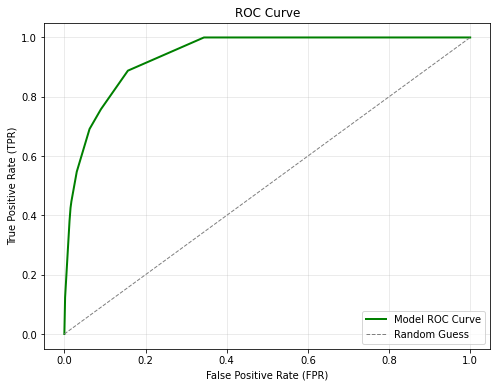

In [0]:
plot_roc_curve(rf_results)

#### 3.3. Gradient-Boosted Trees Classifier

Gradient Boosted Tree Classifier is an ensemble model that builds a series of decision trees in a sequential manner. Each tree is trained to correct the errors of the previous one, making the model stronger with each iteration. It focuses on the mistakes made by earlier trees, improving performance over time. Gradient Boosting is effective for complex tasks and can handle both classification and regression problems, often providing high accuracy in most applications.


##### 3.3.1. Train the model

In [0]:
gbt = GBTClassifier(featuresCol="features", labelCol="loan_status",  maxIter=10, maxDepth=5)

gbt_evaluator = BinaryClassificationEvaluator(labelCol='loan_status', metricName='areaUnderROC')

pipeline.setStages([indexer_gender, indexer_previous, assembler, normalizer, gbt])

Out[41]: Pipeline_61f6df6b46c6

In [0]:
gbt_pipeline_model = pipeline.fit(train)
gbt_results = gbt_pipeline_model.transform(test)

##### 3.3.2. Evaluate the model

In [0]:
print('Confusion Matrix')
gbt_results.groupby("loan_status").pivot("prediction").count().show()

Confusion Matrix
+-----------+----+----+
|loan_status| 0.0| 1.0|
+-----------+----+----+
|          1| 728|2220|
|          0|9868| 608|
+-----------+----+----+



In [0]:
evaluator = BinaryClassificationEvaluator(labelCol='loan_status')
auc_eval  = evaluator.evaluate(gbt_results)
print(f"Area under ROC curve: {auc_eval}")

Area under ROC curve: 0.9522652215855016


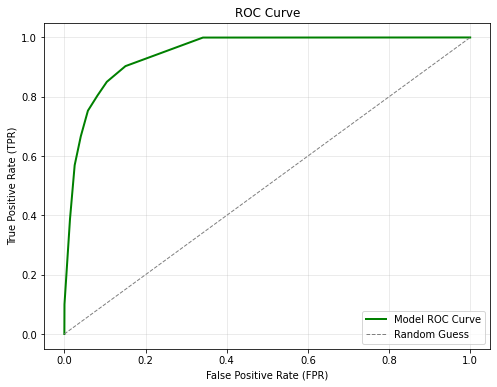

In [0]:
plot_roc_curve(gbt_results)

#### 3.4. Support Vector Machine

A Support Vector Machine (SVM) is a powerful classification algorithm that finds the optimal hyperplane that best separates the data into different classes. It works by maximizing the margin between the classes, ensuring the best generalization to unseen data. Therefore, SVM is particularly effective in high-dimensional spaces.


##### 3.4.1. Train the model

In [0]:
svm = LinearSVC(featuresCol="features", labelCol="loan_status")

svm_evaluator = BinaryClassificationEvaluator(labelCol='loan_status', metricName='areaUnderROC')

pipeline.setStages([indexer_gender, indexer_previous, assembler, normalizer, svm])

Out[46]: Pipeline_61f6df6b46c6

In [0]:
svm_pipeline_model = pipeline.fit(train)
svm_results = svm_pipeline_model.transform(test)

##### 3.4.2. Evaluate the model

In [0]:
print('Confusion Matrix')
svm_results.groupby("loan_status").pivot("prediction").count().show()

Confusion Matrix
+-----------+-----+----+
|loan_status|  0.0| 1.0|
+-----------+-----+----+
|          1| 1069|1879|
|          0|10005| 471|
+-----------+-----+----+



In [0]:
evaluator = BinaryClassificationEvaluator(labelCol='loan_status')
auc_eval  = evaluator.evaluate(svm_results)
print(f"Area under ROC curve: {auc_eval}")

Area under ROC curve: 0.9446075749545512


#### 3.5. Final Model

The model with the best performance of the test set was the Gradient-Boosted Tree Classifier. Since the area under the ROC curve (a higher AUC reflects a higher true positive rate while maintaining a lower false positive rate) achieved by the model is approximately 95%, it is already performing exceptionally well at classifying the data, and therefore, additional tuning or grid search is unnecessary, since the improvements would likely be minimal.

#### 4. Simulating Streaming

We created a Spark streaming pipeline to handle simulated real-time data for loan approval, to demonstrate the value of real-time analytics in financial decision-making. We generated this "real-time data" by simulating it from the existing loan dataset analyzed in this notebook.

In [0]:
spark = SparkSession.builder \
    .appName("Loan Approval Streaming Simulation") \
    .getOrCreate()

# Define schema for loan approval data
loan_schema = StructType([
    StructField("person_age", DoubleType()),
    StructField("person_gender", StringType()),
    StructField("person_education", StringType()),
    StructField("person_income", DoubleType()),
    StructField("person_emp_exp", IntegerType()),
    StructField("person_home_ownership", StringType()),
    StructField("loan_amnt", DoubleType()),
    StructField("loan_intent", StringType()),
    StructField("loan_int_rate", DoubleType()),
    StructField("loan_percent_income", DoubleType()),
    StructField("cb_person_cred_hist_length", DoubleType()),
    StructField("credit_score", IntegerType()),
    StructField("previous_loan_defaults_on_file", StringType()),
    StructField("loan_status", IntegerType())])

input_path = "/FileStore/tables/Shared/Project/loan_data/loan_data_rows/"

# Read the streaming DataFrame from the directory
streaming_df = spark.readStream \
    .option("maxFilesPerTrigger", 10) \
    .option("header", "true") \
    .schema(loan_schema) \
    .csv(input_path)

streaming_df.printSchema()

root
 |-- person_age: double (nullable = true)
 |-- person_gender: string (nullable = true)
 |-- person_education: string (nullable = true)
 |-- person_income: double (nullable = true)
 |-- person_emp_exp: integer (nullable = true)
 |-- person_home_ownership: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- loan_intent: string (nullable = true)
 |-- loan_int_rate: double (nullable = true)
 |-- loan_percent_income: double (nullable = true)
 |-- cb_person_cred_hist_length: double (nullable = true)
 |-- credit_score: integer (nullable = true)
 |-- previous_loan_defaults_on_file: string (nullable = true)
 |-- loan_status: integer (nullable = true)



In [0]:
# Query 1: Average Loan Amount by Loan Status
avg_loan_by_status = streaming_df.groupBy("loan_status").agg(F.avg("loan_amnt").alias("avg_loan_amnt"))

# Query 2: Filter Loans with Amount Greater than 10,000
high_value_loans = streaming_df.filter(F.col("loan_amnt") > 10000)

# Query 3: Count Loans by Intent
loan_intent_count = streaming_df.groupBy("loan_intent").count()

In [0]:
query1 = avg_loan_by_status.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

In [0]:
query2 = high_value_loans.writeStream \
    .outputMode("append") \
    .format("console") \
    .start()

In [0]:
query3 = loan_intent_count.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

As previously demonstrated, various queries were performed on real-time data, generating useful insights. Ultimately, we discovered that investigating real-time data with Spark Streaming is quite beneficial, and we propose that financial institutions use this strategy to assist prevent probable fraud.